In [72]:
import sys
import os
from pathlib import Path

p = Path(os.path.abspath(os.getcwd()))
path = Path(p)
sys.path.insert(0, str(path.parent.absolute()) + '/sub')

from imu_processing import *
from plotting import *
import pandas as pd
import numpy as np
from machine_learning import *
from infer_mag import *
import scipy.signal as signal
from scipy.spatial.transform import Rotation as R
import copy

cwd = str(path.parent.parent.absolute())
data_cwd = cwd + '/Data/'
labels = os.listdir(data_cwd + '/Sample')

model_path = cwd+"/Models/"
svm = load_model(model_path + "SVM20230312")

In [77]:
class MagInfer():
    def __init__(self, data):
        self.acc = self._data_to_lst(data, 'acc')
        self.gyro = self._data_to_lst(data, 'gyro')
        self.mag = self._data_to_lst(data, 'mag')
        self.l = len(self.mag[0])
    
    def _data_to_lst(self, data, name):
        res = []
        lst = ['X', 'Y', 'Z']
        
        for i in lst:
            res.append(data[name + i])
        return res
    
    def _tilted_value(self, original, infered):
        cos_angle = np.dot(original, infered)/(np.linalg.norm(original) * np.linalg.norm(infered))
        return math.degrees(math.acos(cos_angle))
    
    def _get_orientation(self, start, end):
        res = []
        for i in range(3):
            g = np.array(self.gyro[i][start:end]).sum() * 0.01
            res.append(g)
        #print('Roll pitch yaw {} {} {}'.format(res[0], res[1], res[2]))
        
        return self.convert_to_rotation(res)
    
    def convert_to_rotation(self, orientation):
        r = R.from_euler('xyz', orientation, degrees = False)
        
        return r.as_matrix()
    
    def solve(self, ws = 0.1, th = 20, cutoff = 10):
        b, a = signal.butter(5, cutoff/(100/2), btype='highpass')
        interval = int(ws * 100)
        state = 0
        
        tilted_values = []
        self.magnitudes = []
        self.diff_ref_real = []
        
        for t in range(interval, self.l):
            orientation = self._get_orientation(t-interval, t)
            real_mag = np.array([self.mag[i][t] for i in range(3)])
            reference_mag = np.array([self.mag[i][t-interval] for i in range(3)])
            infered_mag = np.matmul(np.linalg.inv(orientation), reference_mag)
            
            magnitude_mag = 0
            for i in range(3):
                magnitude_mag += (real_mag[i] * real_mag[i])
            
            magnitude_mag = math.sqrt(magnitude_mag)
            self.magnitudes.append(magnitude_mag)
            tilted_angle = self._tilted_value(infered_mag, real_mag)
            tilted_values.append(tilted_angle)
            self.diff_ref_real.append(self._tilted_value(reference_mag, real_mag))
            
            if tilted_angle >= th and state == 0:
                print('detect {}'.format(t))
                state = 1
            
            
        return tilted_values

C:\Users\jaemi\lab_magacc/Data/Test_inside/NoObject/Imu 2023-04-10 12-11-01


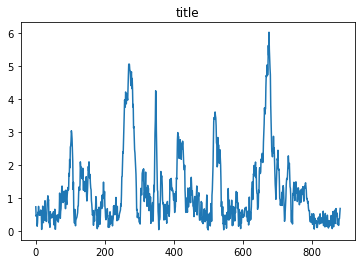

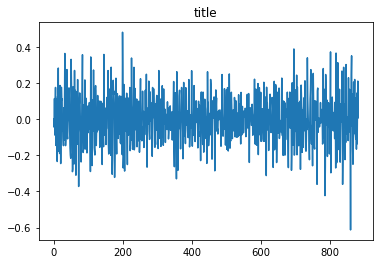

In [71]:
import scipy.signal as signal

path = data_cwd + 'test0331/'
#path = data_cwd + 'Test_outside/outside'
path = data_cwd + 'Test_nature2'
path = data_cwd + 'Test_inside'
b, a = signal.butter(5, 10/(100/2), btype='highpass')
imu_data = IMU(path)
f = imu_data[4]
print(f.path)
data = f.data

tmp = MagInfer(data)
res = tmp.solve()
plot_graph(res)
filtered_data = signal.filtfilt(b, a, tmp.magnitudes)
plot_graph(filtered_data)

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlack/Imu 2023-03-30 16-56-07


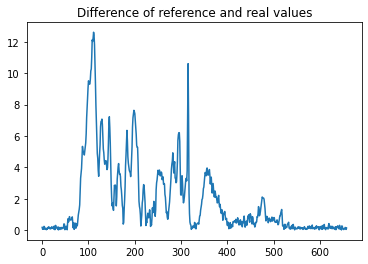

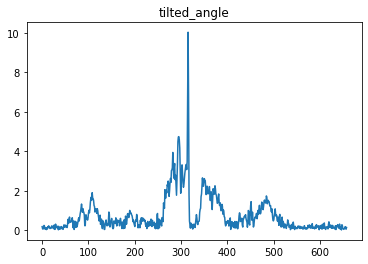

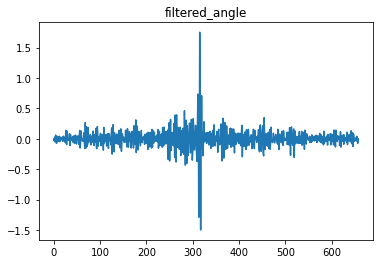

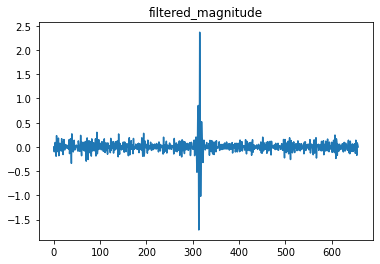

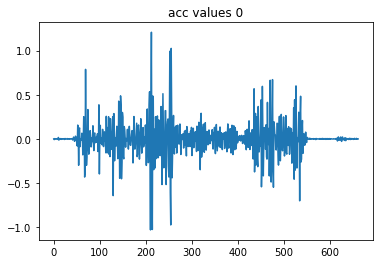

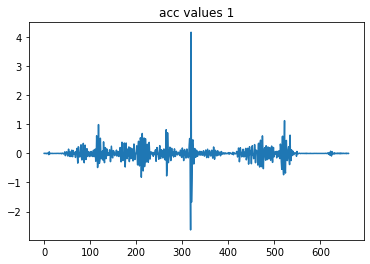

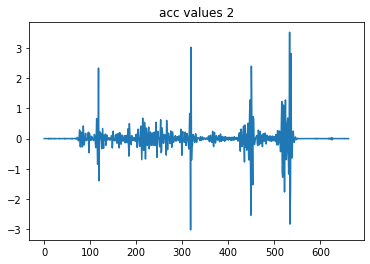

angle max 10.04132219701518  magnitude max : 2.366923968375171

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlack/Imu 2023-03-30 16-56-33


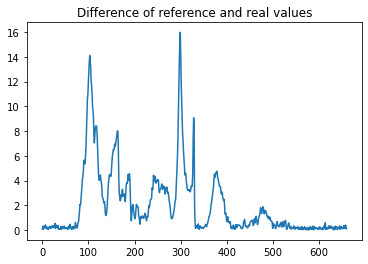

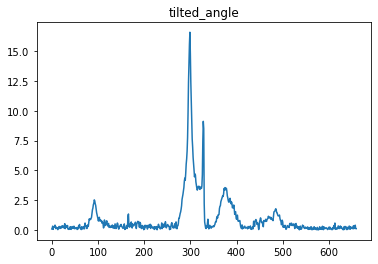

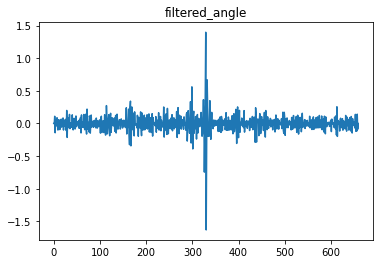

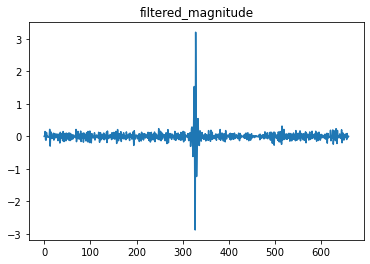

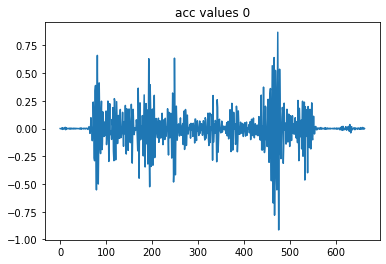

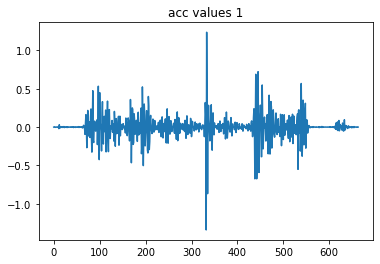

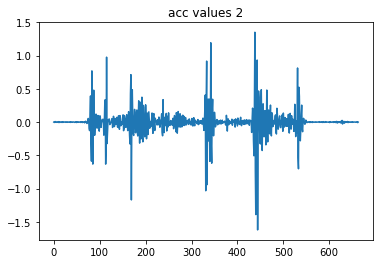

angle max 16.58766386505451  magnitude max : 3.2056803576511537

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlack/Imu 2023-03-30 16-56-47


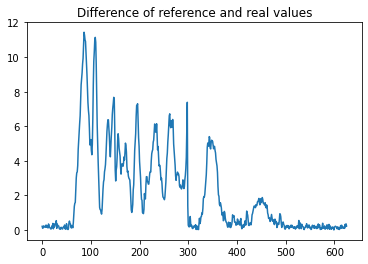

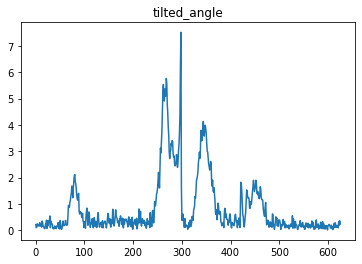

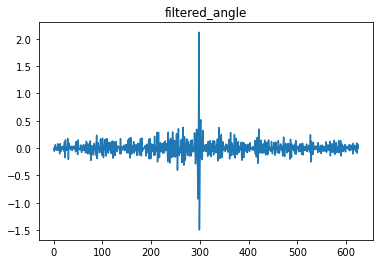

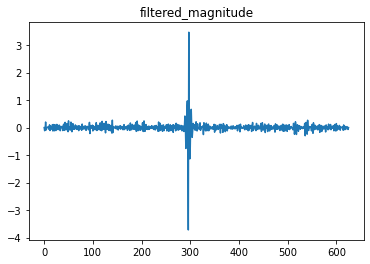

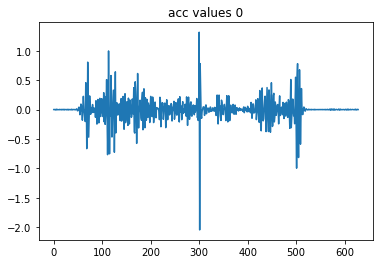

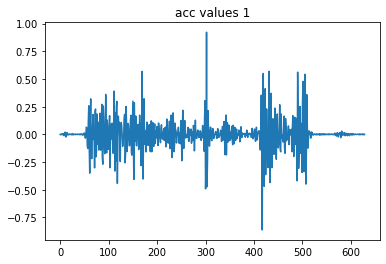

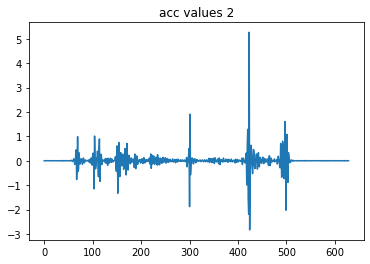

angle max 7.519508592708799  magnitude max : 3.719657386258984

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlack/Imu 2023-03-30 16-57-01


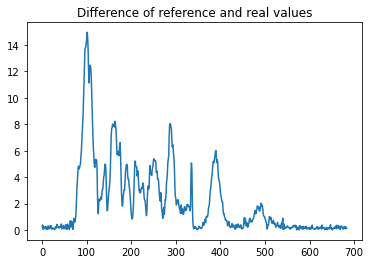

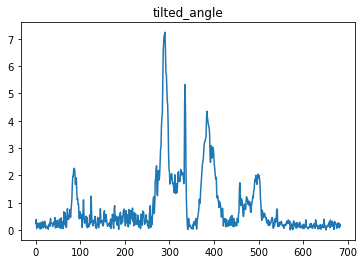

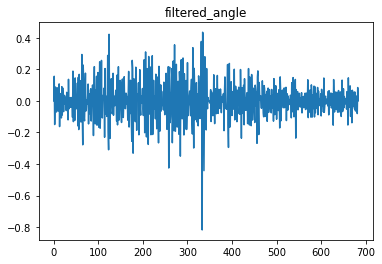

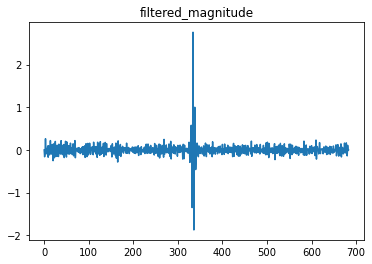

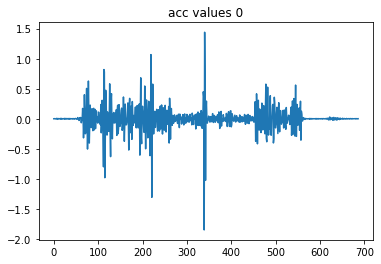

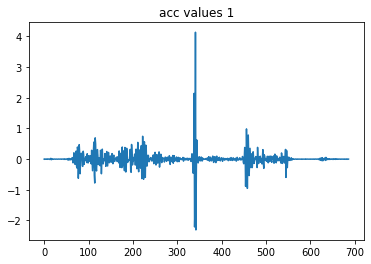

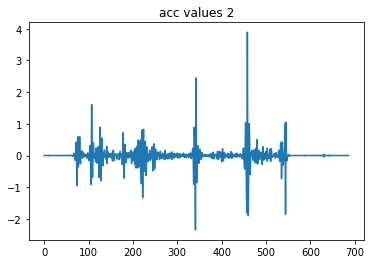

angle max 7.2349959974074505  magnitude max : 2.7569579883840944

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlack/Imu 2023-03-30 16-57-15


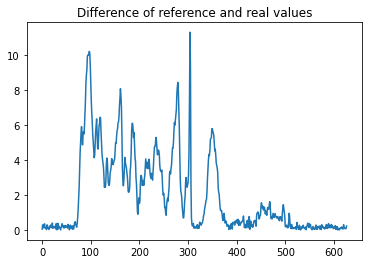

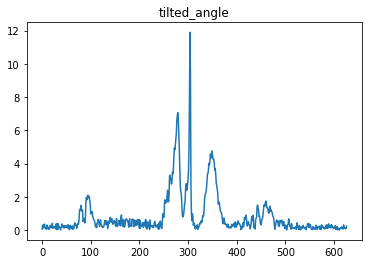

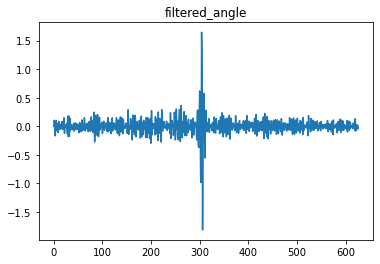

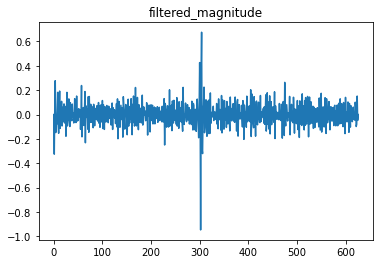

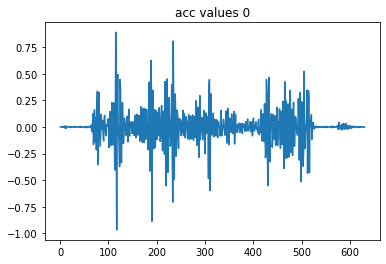

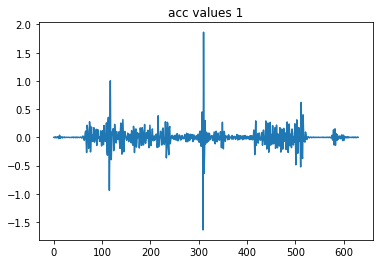

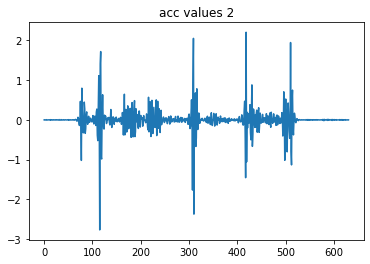

angle max 11.903283783498404  magnitude max : 0.9474111658601492

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlue/Imu 2023-03-30 17-00-39


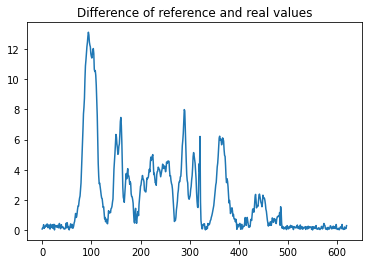

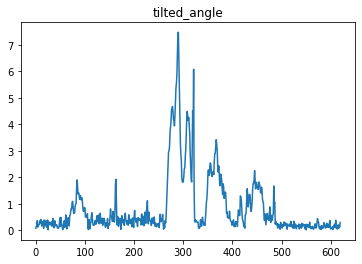

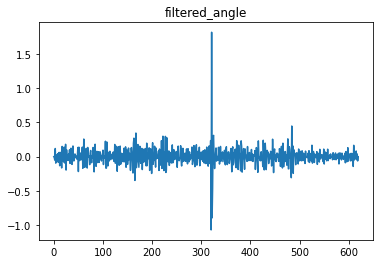

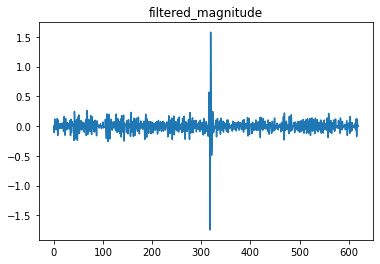

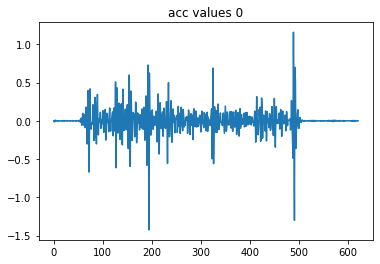

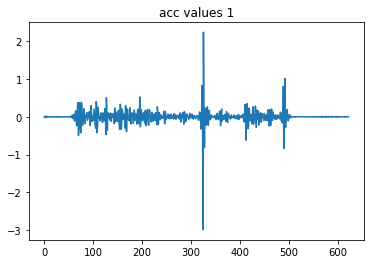

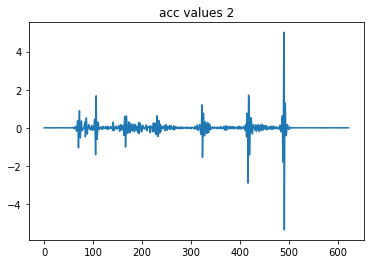

angle max 7.479971657941418  magnitude max : 1.7446421161680346

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlue/Imu 2023-03-30 17-01-04


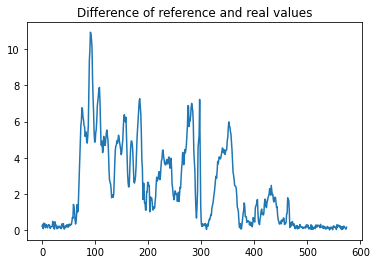

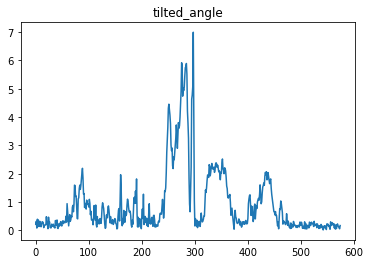

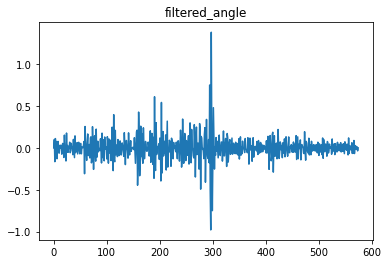

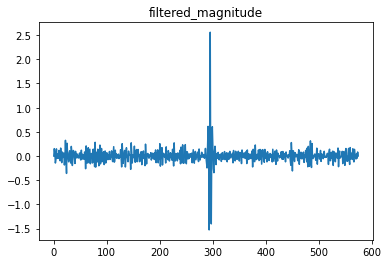

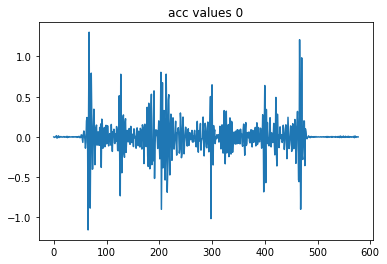

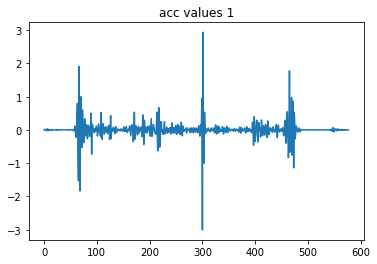

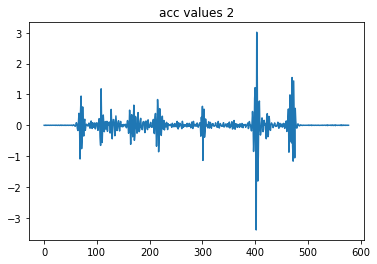

angle max 6.991576221652946  magnitude max : 2.5592458882589577

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlue/Imu 2023-03-30 17-01-17
detect 275


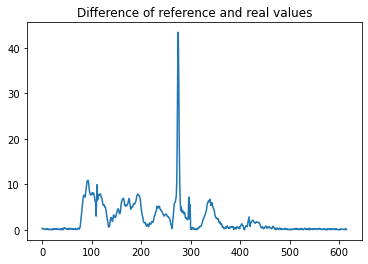

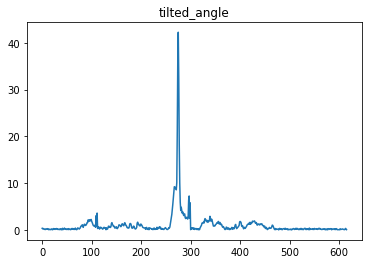

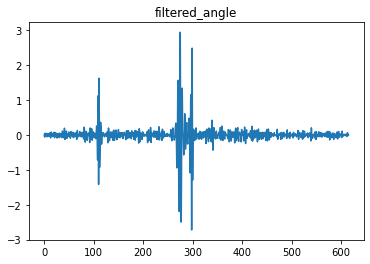

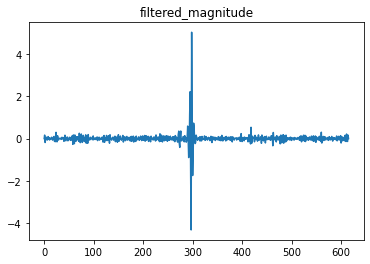

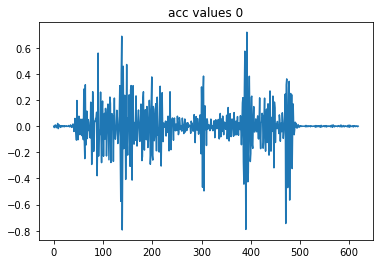

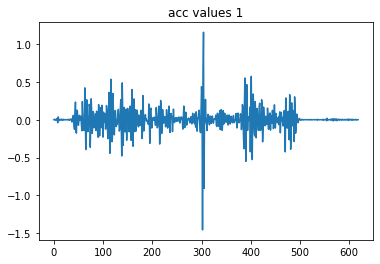

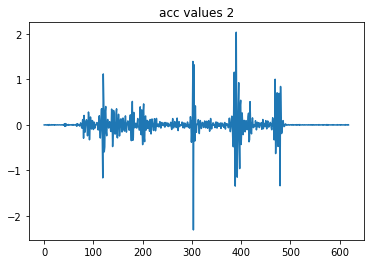

angle max 42.2564946776167  magnitude max : 5.01753987460362

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlue/Imu 2023-03-30 17-01-31


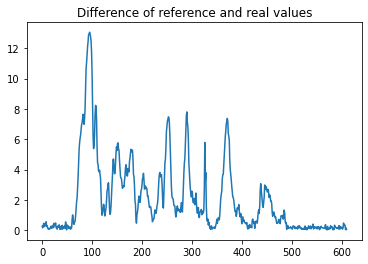

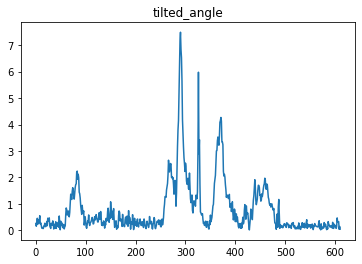

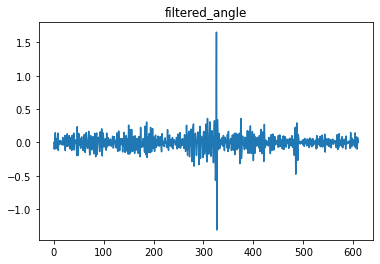

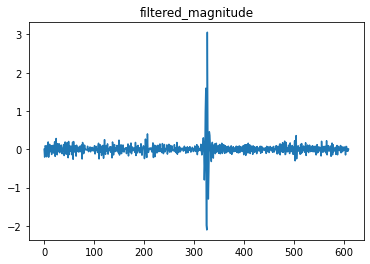

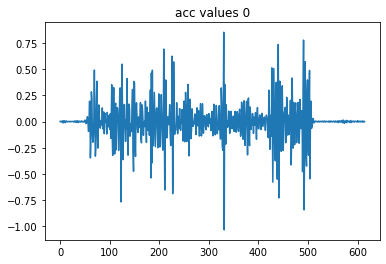

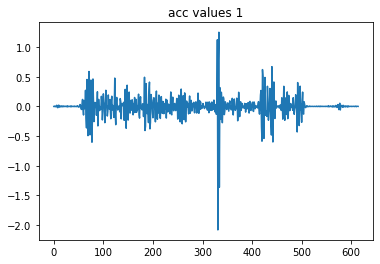

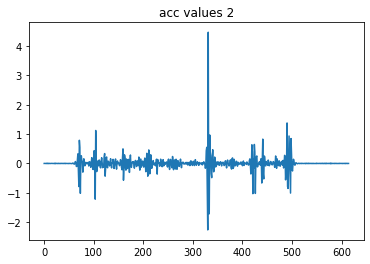

angle max 7.489345909113364  magnitude max : 3.0575427209693196

C:\Users\jaemi\lab_magacc/Data/Test_nature3/bandgripBlue/Imu 2023-03-30 17-01-44


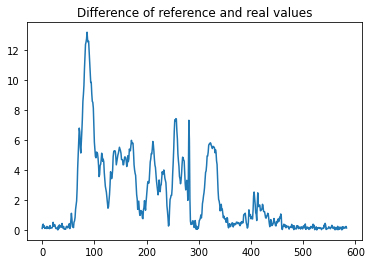

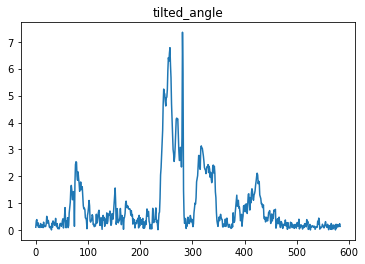

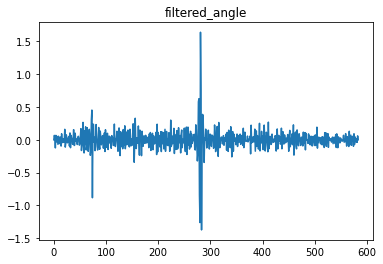

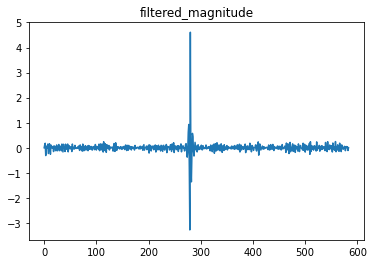

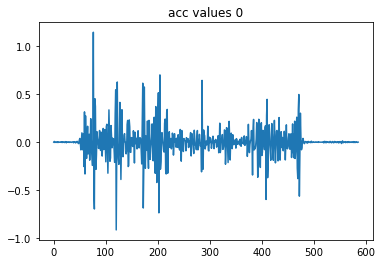

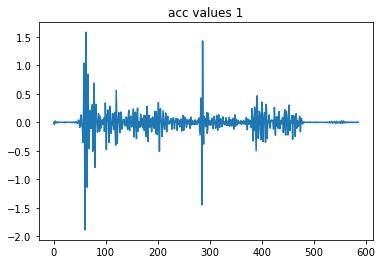

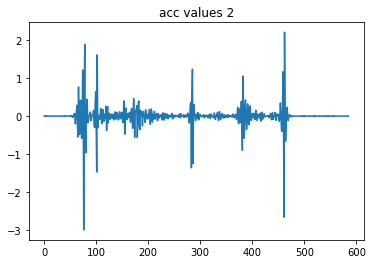

angle max 7.349969127002702  magnitude max : 4.6099406968159

C:\Users\jaemi\lab_magacc/Data/Test_nature3/batterypack/Imu 2023-03-30 17-03-59


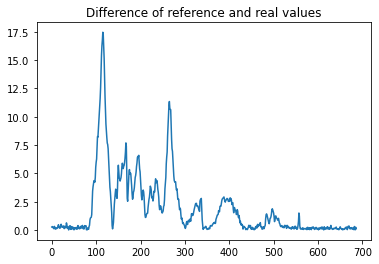

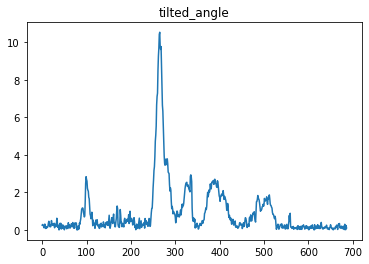

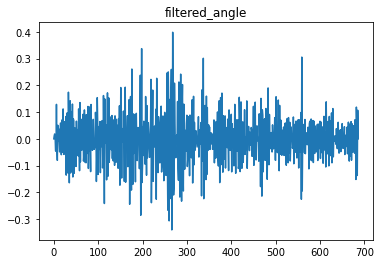

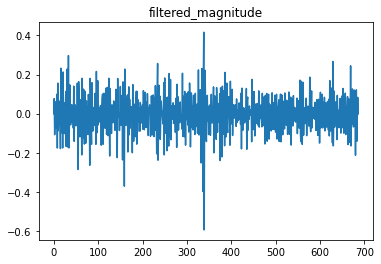

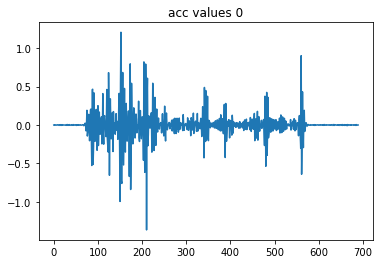

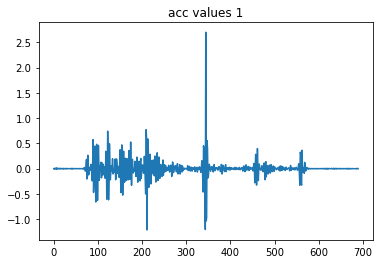

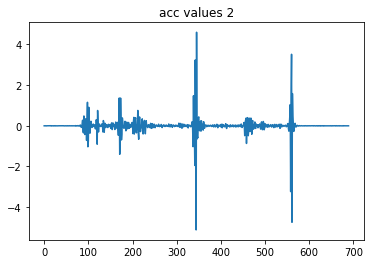

angle max 10.526926212817006  magnitude max : 0.59504666597673

C:\Users\jaemi\lab_magacc/Data/Test_nature3/batterypack/Imu 2023-03-30 17-04-12


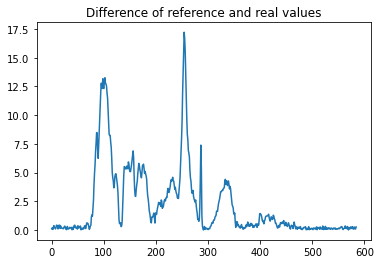

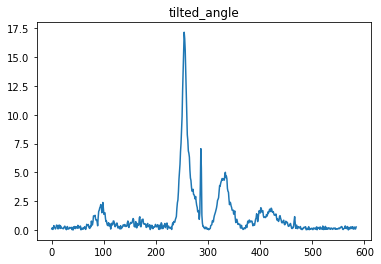

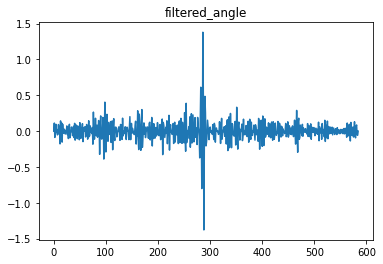

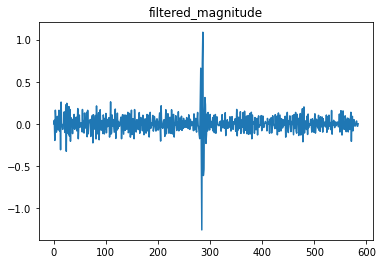

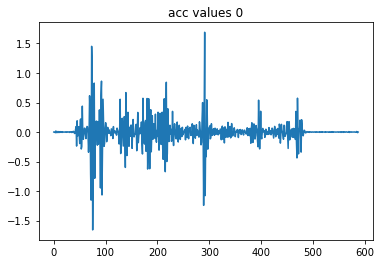

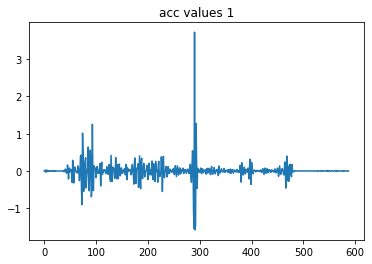

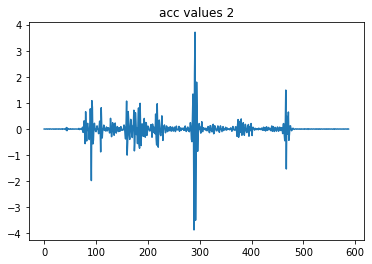

angle max 17.168887746056775  magnitude max : 1.2596056188872746

C:\Users\jaemi\lab_magacc/Data/Test_nature3/batterypack/Imu 2023-03-30 17-04-28


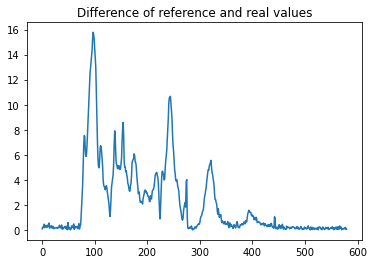

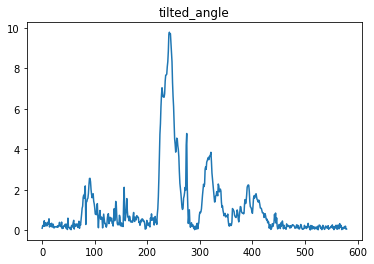

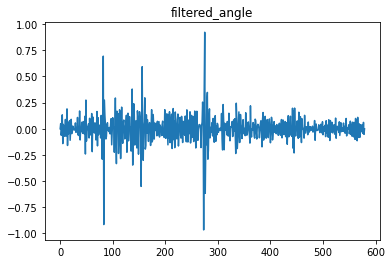

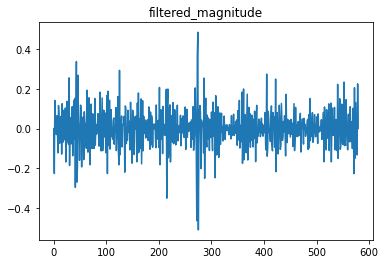

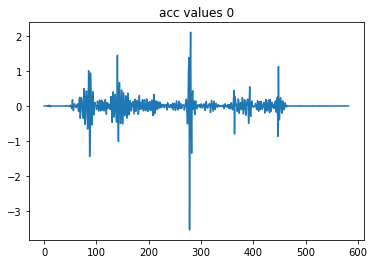

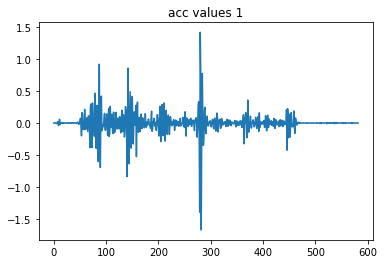

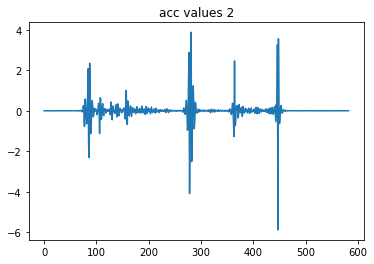

angle max 9.782625294103168  magnitude max : 0.5106830151210665

C:\Users\jaemi\lab_magacc/Data/Test_nature3/batterypack/Imu 2023-03-30 17-04-41


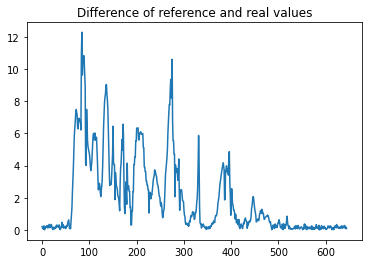

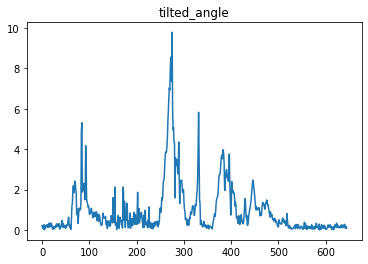

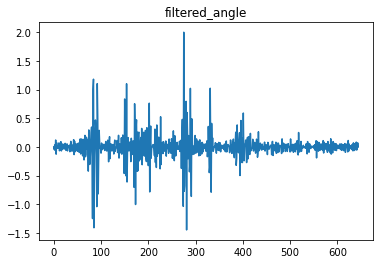

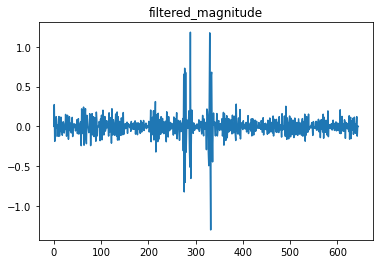

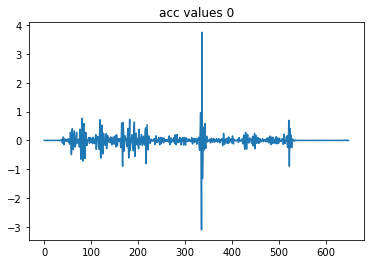

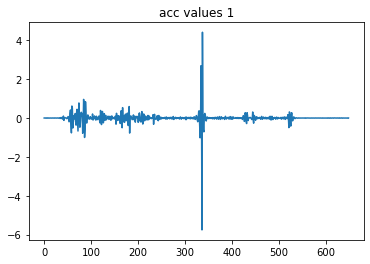

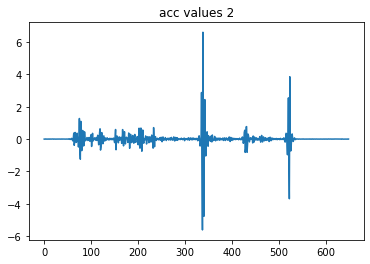

angle max 9.784658254397055  magnitude max : 1.3028800709456563

C:\Users\jaemi\lab_magacc/Data/Test_nature3/batterypack/Imu 2023-03-30 17-04-56


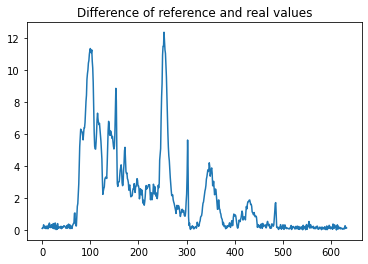

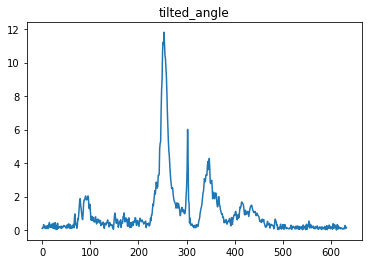

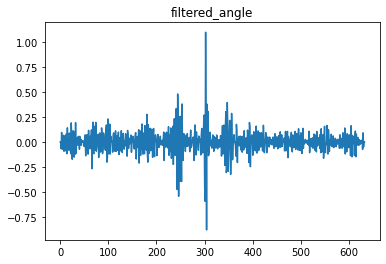

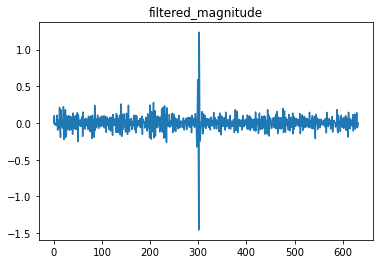

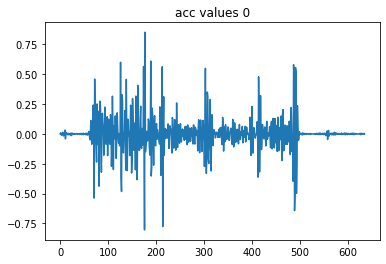

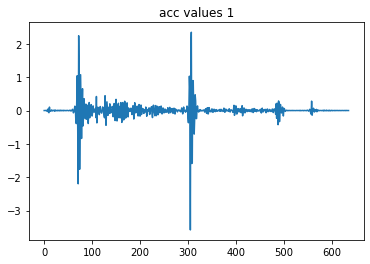

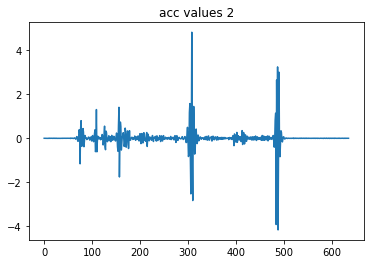

angle max 11.806775709298972  magnitude max : 1.4575693658391884

C:\Users\jaemi\lab_magacc/Data/Test_nature3/blackcowlabsGriptokBlack/Imu 2023-03-30 16-51-46


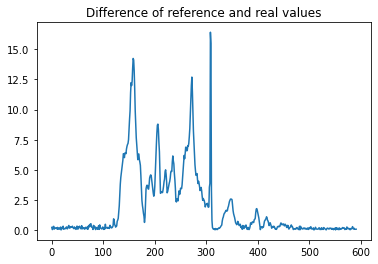

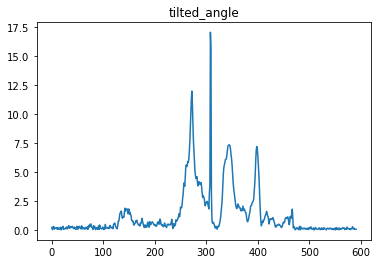

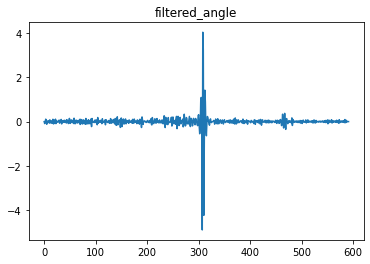

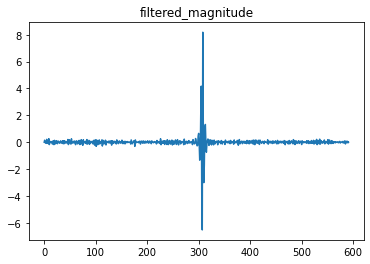

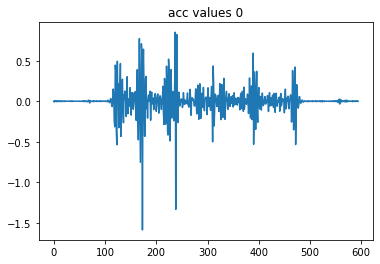

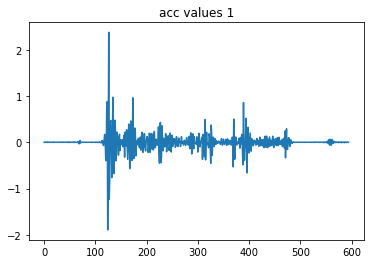

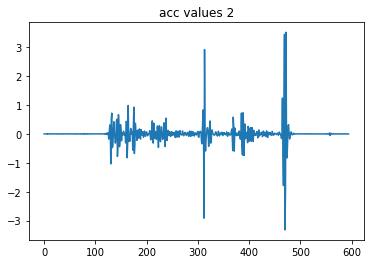

angle max 17.0798866220981  magnitude max : 8.181085147919632

C:\Users\jaemi\lab_magacc/Data/Test_nature3/blackcowlabsGriptokBlack/Imu 2023-03-30 16-52-00
detect 261


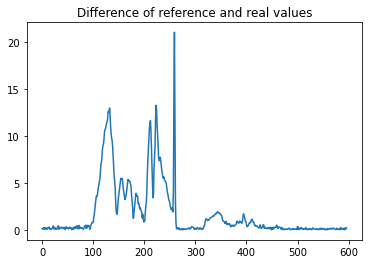

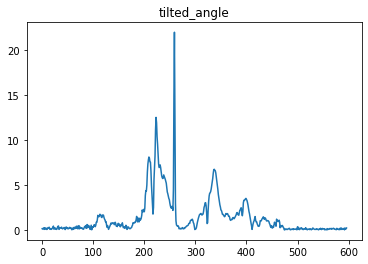

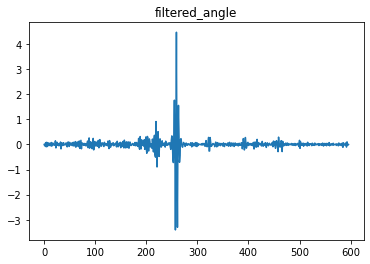

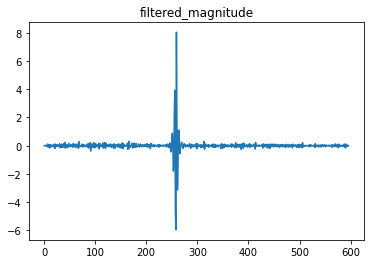

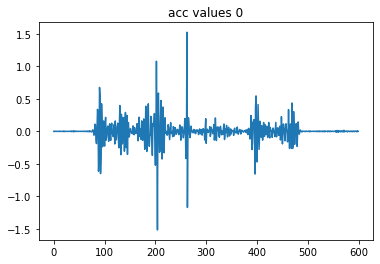

In [ ]:
class Values():
    def __init__(self):
        self.angles = []
        self.magnitudes = []
        
    def append_values(self, angle, magnitude):
        self.angles.append(angle)
        self.magnitudes.append(magnitude)

path = data_cwd + 'Test_nature3'
#path = data_cwd + 'Test_inside'
imu_data = IMU(path)

start, end = 0, 65
b, a = signal.butter(5, 20/(100/2), btype='highpass')

label_values = {label : Values() for label in labels}

for i in range(start, end):
    f = imu_data[i]
    print(f.path)
    data = f.data
    
    tmp = MagInfer(data)
    tilted_angle = tmp.solve(ws = 0.02)
    
    plot_graph(tmp.diff_ref_real, 'Difference of reference and real values')
    plot_graph(tilted_angle, title= 'tilted_angle')
    filtered_data = signal.filtfilt(b, a, tilted_angle)
    plot_graph(filtered_data, 'filtered_angle')
    
    magnitude = tmp.magnitudes
    filtered_data = signal.filtfilt(b, a, magnitude)
    plot_graph(filtered_data, 'filtered_magnitude')
    
    angle_max = abs(max(tilted_angle)) if abs(max(tilted_angle)) > abs(min(tilted_angle)) else abs(min(tilted_angle))
    mag_max = abs(max(filtered_data)) if abs(max(filtered_data)) > abs(min(filtered_data)) else abs(min(filtered_data))
    label_values[f.label].append_values(angle_max, mag_max)
    
    # for mags
    for t in range(3):
        #plot_graph(tmp.mag[t], title = 'mag values ' + str(t))
        filtered_data = signal.filtfilt(b, a, tmp.acc[t])
        plot_graph(filtered_data, title = 'acc values ' + str(t))
        #plot_graph(filtered_data, title = 'mag values ' + str(t))
        
    
    print('angle max {}  magnitude max : {}\n'.format(angle_max, mag_max))

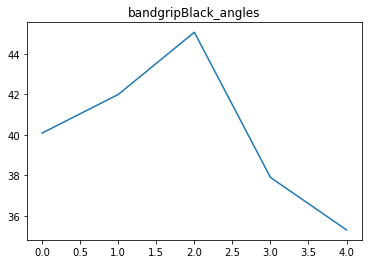

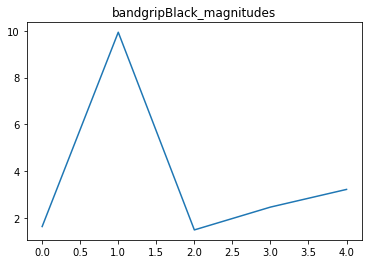

---------------------------------------------------


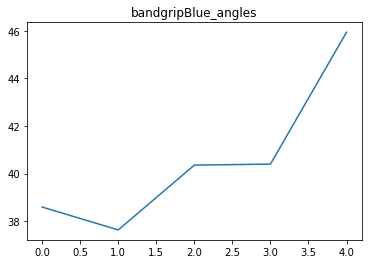

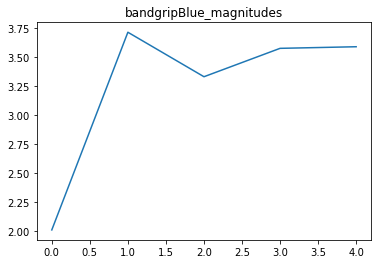

---------------------------------------------------


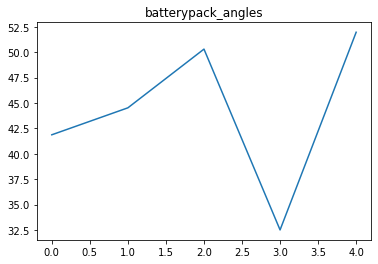

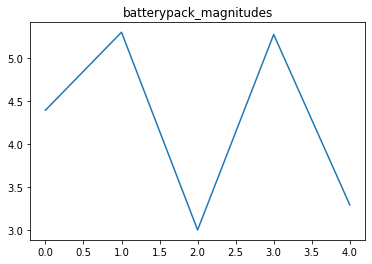

---------------------------------------------------


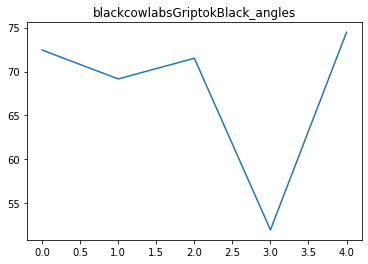

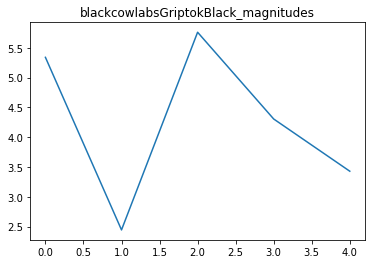

---------------------------------------------------


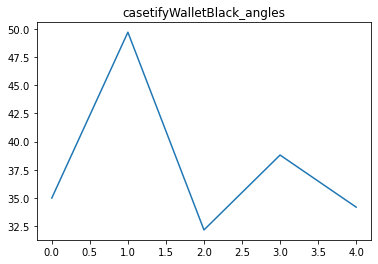

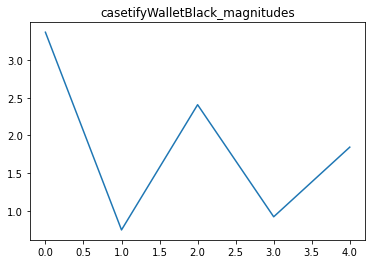

---------------------------------------------------


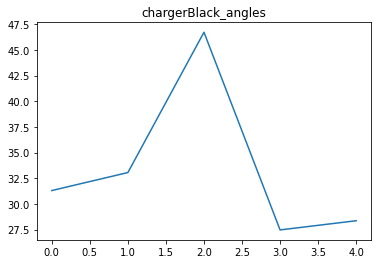

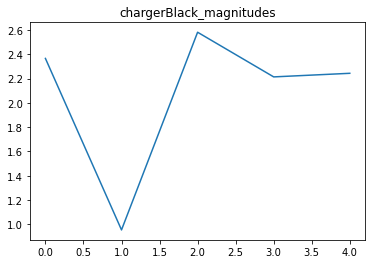

---------------------------------------------------


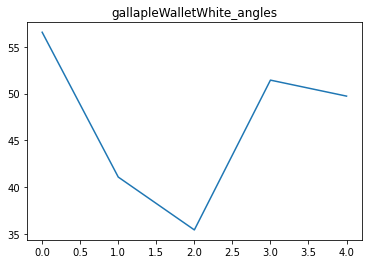

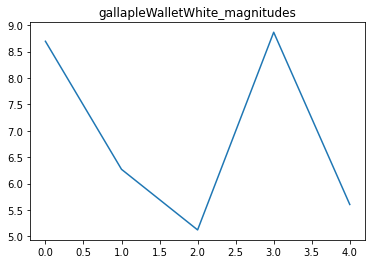

---------------------------------------------------


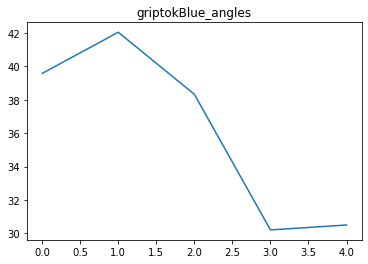

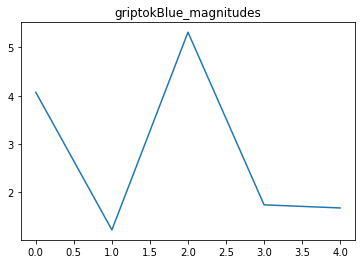

---------------------------------------------------


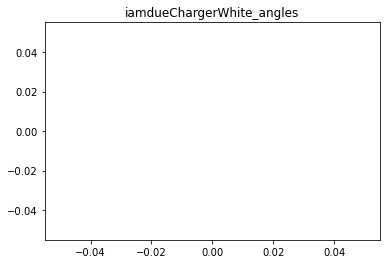

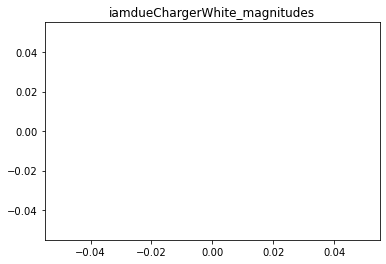

---------------------------------------------------


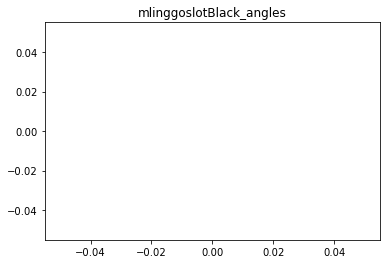

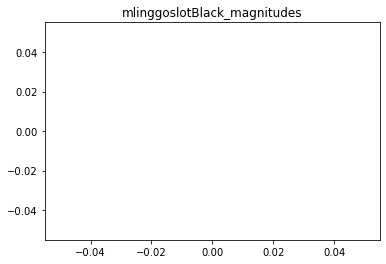

---------------------------------------------------


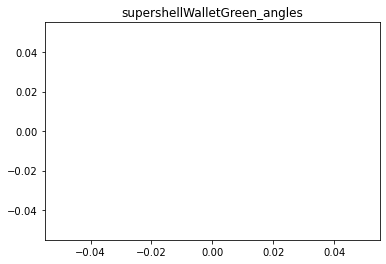

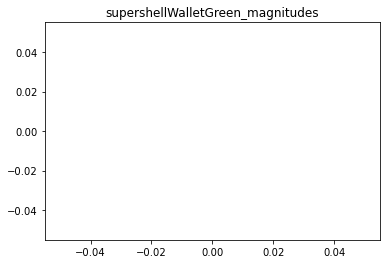

---------------------------------------------------


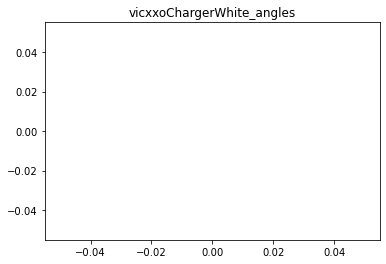

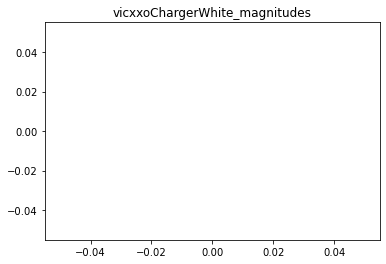

---------------------------------------------------


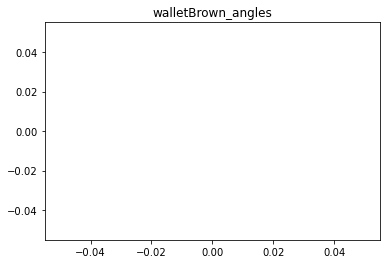

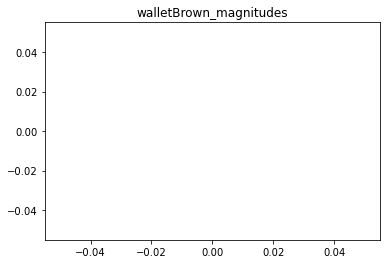

---------------------------------------------------


In [51]:
for key, value in label_values.items():
    plot_graph(value.angles, title = key + '_angles')
    plot_graph(value.magnitudes, title = key + '_magnitudes')
    print('---------------------------------------------------')